In [1]:
import time
import torch
import numpy as np
from numba import jit
import networkx as nx
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
from abc import abstractmethod

class BaseLabelPropagation:
    '''Base class for label propagation models.
    
    Parameters
    ----------
    adj_matrix: torch.FloatTensor
        Adjacency matrix of the graph.
    '''
    def __init__(self, adj_matrix):
        self.norm_adj_matrix = self._normalize(adj_matrix)
        self.n_nodes = adj_matrix.size(0)
        self.one_hot_labels = None 
        self.n_classes = None
        self.labeled_mask = None
        self.predictions = None

    @staticmethod
    @abstractmethod
    def _normalize(adj_matrix):
        raise NotImplementedError('_normalize must be implemented')

    @abstractmethod
    def _propagate(self):
        raise NotImplementedError('_propagate must be implemented')

    def _one_hot_encode(self, labels):        
        # Get the number of classes
        classes = torch.arange(0, 11, device=labels.device)
        classes = classes[classes != -1]
        self.n_classes = classes.size(0)

        # One-hot encode labeled data instances and zero rows corresponding to unlabeled instances
        unlabeled_mask = (labels == -1)
        #labels = labels.clone()  # defensive copying
        labels[unlabeled_mask] = 0
        self.one_hot_labels = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float, device=labels.device)
        
        self.one_hot_labels = self.one_hot_labels.scatter(1, labels.unsqueeze(1), 1)
        self.one_hot_labels[unlabeled_mask, 0] = 0

        self.labeled_mask = ~unlabeled_mask

    def fit(self, labels, max_iter, tol, verbose=True):
        '''Fits a semi-supervised learning label propagation model.
        
        labels: torch.LongTensor
            Tensor of size n_nodes indicating the class number of each node.
            Unlabeled nodes are denoted with -1.
        max_iter: int
            Maximum number of iterations allowed.
        tol: float
            Convergence tolerance: threshold to consider the system at steady state.
        '''
        self._one_hot_encode(labels)

        self.predictions = self.one_hot_labels.clone()
        prev_predictions = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float, device=labels.device)

        for i in range(max_iter):
            # Stop iterations if the system is considered at a steady state
            variation = torch.abs(self.predictions - prev_predictions).sum().item()
            
            if variation < tol:
                if verbose:
                    print(f'The method stopped after {i} iterations, variation={variation:.4f}.')
                break

            prev_predictions = self.predictions.clone()
            self._propagate()

    def predict(self):
        return self.predictions

    def predict_classes(self):
        return self.predictions.max(dim=1).indices

In [3]:
class LabelSpreading(BaseLabelPropagation):
    def __init__(self, adj_matrix):
        super().__init__(adj_matrix)
        self.alpha = None

    @staticmethod
    def _normalize(adj_matrix):
        '''Computes D^-1/2 * W * D^-1/2'''
        degs = adj_matrix.sum(dim=1)
        norm = torch.pow(degs, -0.5)
        norm[torch.isinf(norm)] = 1
        return adj_matrix * norm[:, None] * norm[None, :]

    def _propagate(self):
        self.predictions = (
            self.alpha * torch.matmul(self.norm_adj_matrix, self.predictions)
            + (1 - self.alpha) * self.one_hot_labels
        )
        #self.predictions[self.labeled_mask] = self.one_hot_labels[self.labeled_mask]
    
    def fit(self, labels, max_iter=1000, tol=1e-3, alpha=0.5, verbose=True):
        '''
        Parameters
        ----------
        alpha: float
            Clamping factor.
        '''
        self.alpha = alpha
        super().fit(labels, max_iter, tol, verbose)

In [4]:
from joblib import Parallel, delayed


@jit(nopython=True)
def process_weight_matrix(W):
    W = np.maximum(W, W.T)
    row_sums = W.sum(axis=1)
    W /= row_sums[:, np.newaxis]
    np.fill_diagonal(W, 0)
    return W


@jit(nopython=True)
def generate_weight_matrix(n, low, high):
    W = np.random.uniform(low, high, size=(n, n))
    W = process_weight_matrix(W)
    return W


def create_sparse_matrix(n, m, zero_percentage, rng_seed=42):
    np.random.seed(rng_seed)  

    total_elements = n * m
    num_zeros = int(zero_percentage * total_elements)
    num_non_zeros = total_elements - num_zeros

    a = np.zeros(num_zeros, dtype=np.uint8)
    b = np.random.randint(1, 11, num_non_zeros)

    elements = np.concatenate((a, b))
    np.random.shuffle(elements)

    sparse_matrix = np.reshape(elements, (n, m))
    return sparse_matrix


def initialize_population(population_len, n, value_range, n_jobs=-1):
    population = Parallel(n_jobs=n_jobs)(
        delayed(generate_weight_matrix)(n, *value_range) for _ in range(population_len)
    )
    return population


In [89]:
@jit(nopython=True)
def get_test_indices(data, test_size=0.3, rng_seed=42):
    # np.random.seed(rng_seed)
    test_indices_list = []
    
    for row in data:
        nonzero_indices = np.nonzero(row)[0]
        num_indices_to_keep = int(np.ceil(test_size * len(nonzero_indices)))
        selected_indices = np.random.choice(nonzero_indices, size=num_indices_to_keep, replace=False)
        test_indices_list.append(selected_indices)
    
    return test_indices_list


def run_label_spreading(W, original_data, predicted_data, test_indices, alpha=0.5, verbose=True):   # change alpha to .8
    adj_matrix_t = torch.FloatTensor(W)

    for i in range(original_data.shape[0]):
        labels_t = torch.LongTensor( original_data[i, :].copy() )    # might need to make a copy of original_data for warning suppression
        
        if len(test_indices[i]):
            labels_t[test_indices[i]] = 0
        
        labels_t[labels_t == 0] = -1
            
        label_spreading = LabelSpreading(adj_matrix_t)
        label_spreading.fit(labels_t, alpha=alpha, verbose=verbose)
        label_spreading_output_labels = label_spreading.predict_classes()

        predicted_data[i, :] = label_spreading_output_labels


@jit(nopython=True)
def mean_absolute_error(y_true, y_pred, denom):
    return np.sum(np.abs(y_true - y_pred)) / denom


@jit(nopython=True)
def mean_squared_error(y_true, y_pred, denom):
    return np.sum((y_true - y_pred) ** 2) / denom


def get_fitness(original_data, predicted_data, test_indices):
    e = []

    for i in range(original_data.shape[0]):
        if len(test_indices[i]):
            y_true = original_data[i, test_indices[i]].astype(np.int8)
            y_pred = predicted_data[i, test_indices[i]].astype(np.int8)
            mse = mean_squared_error(y_true, y_pred, len(y_true))
            e.append(mse)
        else:
            raise Exception('empty test sample')
                
    return -np.sum(e) / original_data.shape[0]


def evaluate_population(population, original_data, test_indices, verbose=True):
    scores = [ [i, None, None] for i in range(len(population)) ] 
    
    for i in range(len(population)):
        predicted_data = np.empty_like(original_data)
        run_label_spreading(population[i], original_data, predicted_data, test_indices, verbose=verbose)
        scores[i][1] = get_fitness(original_data, predicted_data, test_indices)
        scores[i][2] = predicted_data
        
    return scores

In [90]:
import random

@jit(nopython=True)
def crossover(W1, W2, W1_score, W2_score, alpha=0.5):
    beta = 1 - alpha
    combined_matrix = alpha * W1 + beta * W2 if W1_score > W2_score else alpha * W2 + beta * W1
    return process_weight_matrix(combined_matrix)
    

def elitist_selection(sorted_scores, elite_percentage):
    elite_size = int(len(sorted_scores) * elite_percentage)
    elites_indices = [ sorted_scores[i][0]  for i in range(elite_size) ]
    return elites_indices


def tournament_selection(scores, elite_indices, num_parents):
    parents_indices = elite_indices.copy()
    parents_indices_set = set(parents_indices)
    individuals_indices = set(range(len(scores)))

    while len(parents_indices) < num_parents:
        available_indices = list(individuals_indices - parents_indices_set)
        tournament_indices = np.random.choice(available_indices, len(available_indices), replace=False)

        tournament_scores = [ (i, scores[i][1]) for i in tournament_indices ]
        winner_idx = max(tournament_scores, key=lambda x: x[1])[0]

        if winner_idx not in parents_indices:
            parents_indices.append(winner_idx)
            parents_indices_set.add(winner_idx)
    
    return parents_indices 


@jit(nopython=True)
def mutate_matrix(W, mutation_rate, mutation_range):
    mutated_matrix = np.copy(W)
    rows, cols = mutated_matrix.shape
    num_mutations = int(np.ceil(mutation_rate * rows * cols))

    mutation_indices = np.random.randint(0, rows * cols, num_mutations)
    row_indices = mutation_indices // cols
    col_indices = mutation_indices % cols

    mutation_values = np.random.uniform(mutation_range[0], mutation_range[1], num_mutations)

    for i in range(num_mutations):
        mutated_matrix[row_indices[i], col_indices[i]] += mutation_values[i]
        mutated_matrix[row_indices[i], col_indices[i]] = max(0.0, min(1.0, mutated_matrix[row_indices[i], col_indices[i]]))

    return process_weight_matrix(mutated_matrix)

In [91]:
import os
import psutil

memory_gb = psutil.virtual_memory().total / 1024**3
print(f'{memory_gb=}')

# num_users = int(1000)
num_users = 600
print(f'{num_users=}')

# num_items = 18
num_items = 10
print(f'{num_items=}')

num_cpus = os.cpu_count()
print(f'{num_cpus=}')

partitions = num_cpus - 1
population_len = 35
print(f'{partitions=}, {population_len=}')
value_range = (1, 10**5)

memory_gb=47.835899353027344
num_users=600
num_items=10
num_cpus=16
partitions=15, population_len=35


In [92]:
original_data = create_sparse_matrix(num_items, num_users, 0.7)
original_data.shape, np.count_nonzero(original_data) / original_data.size * 100

((10, 600), 30.0)

In [93]:
def run_simulated_annealing(og_individual, og_fitness, data, test_indices, tolorance, max_iterations, mutation_rate, mutation_range):
    best_fitness = og_fitness
    new_individual = og_individual.copy()

    for _ in range(max_iterations):
        new_individual = mutate_matrix(new_individual, mutation_rate, mutation_range)
        new_individual_fitness = evaluate_population([new_individual], data, test_indices, verbose=False)[0][1]
        if np.isclose(new_individual_fitness, best_fitness, atol=tolorance):
            return new_individual
                
    return None

In [94]:
def get_duplicates(l):
    d = dict()
    dups_indices = []

    for idx, v in enumerate(l):
        if v in d:
            dups_indices.append(idx)
        else:
            d[v] = True
    
    return dups_indices

In [95]:
def restart_population(survivors, population_len, n, value_range):
    new_population = survivors.copy()
    new_population.extend(initialize_population(population_len=population_len, n=n, value_range=value_range))
    return new_population

In [144]:
epochs = 250
hist = np.zeros(shape=(epochs, 2), dtype=np.float64)

test_indices = get_test_indices(original_data, test_size=0.4)
max_iterations_values = [20 + (i // 10) for i in range(1, 250 + 1)]   # reduce max_iterations towards the end too much overhead
tolorance_values = np.linspace(0.7, 0.85, epochs)
mutation_rate_values = np.linspace(0.01, 0.00001, epochs)
population = initialize_population(population_len=population_len, n=num_users, value_range=value_range)

In [145]:
og_population = population.copy()

In [146]:
original_data[0, test_indices[0]]

array([ 8,  3,  7,  8,  5,  8,  1,  3,  2,  9,  8,  4,  9,  9,  4,  9,  6,
        9,  6, 10,  1,  5,  3,  5,  7,  7, 10,  6,  9,  5,  9, 10,  5,  2,
        2,  4,  8,  7,  5,  7,  3,  5,  5,  2,  1,  1, 10, 10,  8, 10,  6,
        2,  2,  4, 10,  9,  1,  8, 10,  4,  7,  6,  4,  3, 10,  7,  3,  3])

In [147]:
elites_indices = []

for i in range(epochs):
    
    avg_value = np.average(population[0])
    l = (epochs - i) / 100 * avg_value
    mutation_range = ( -avg_value -l, avg_value + l )
    mutation_rate = mutation_rate_values[i]
    tolorance = tolorance_values[i]
    max_iterations = max_iterations_values[i]

    scores = evaluate_population(population, original_data, test_indices, verbose=False)

    if i < epochs // 3:
        dups_indices = get_duplicates([ score[1] for score in scores ])
        while len(dups_indices):
            for idx in dups_indices:
                population[idx] = mutate_matrix(population[idx], mutation_rate, mutation_range)     # this doesnt help after a certain point
                scores = evaluate_population(population, original_data, test_indices, verbose=False)
                dups_indices = get_duplicates([ score[1] for score in scores ])

    valid_scores = [x for x in scores if x[1] != np.finfo(float).max]    
    average_fitness = sum(x[1] for x in valid_scores) / len(valid_scores)
    valid_scores = sorted(valid_scores, key=lambda x:x[1], reverse=True)

    best_fitness = valid_scores[0][1]
    print(f'{i}: {average_fitness=}, {best_fitness=}')

    hist[i][0] = average_fitness
    hist[i][1] = best_fitness
    
    elites_indices = elitist_selection(valid_scores, 0.4)
    parents_indices = tournament_selection(valid_scores, elites_indices, population_len // 2)
    random.shuffle(parents_indices)

    parent_pairs = [(parents_indices[j], parents_indices[j + 1]) for j in range(0, len(parents_indices) - 1, 2)]   

    alpha = 0.7
    new_population = [
            crossover(
                population[pair[0]], 
                population[pair[1]],
                scores[pair[0]][1], 
                scores[pair[1]][1], 
                alpha=alpha
            ) for pair in parent_pairs 
        ]

    diff = population_len - len(new_population) - len(parents_indices)
    if diff > 0:        
        random.shuffle(parents_indices)
        parent_pairs = [(parents_indices[j], parents_indices[j + 1]) for j in range(0, len(parents_indices) - 1, 2)]   
        for j in range(diff):
            idx, fitness = valid_scores[j][0], valid_scores[j][1]
            new_individual = run_simulated_annealing(population[idx], fitness, original_data, test_indices, tolorance, max_iterations, mutation_rate, mutation_range) 
            if new_individual is not None:
                new_population.append(new_individual)
                print('changed', end=' ')
            else:
                # new_population.append(generate_weight_matrix(num_users, np.min(population[0]), np.max(population[0])))
                new_population.append(generate_weight_matrix(num_users, *value_range))
        print('\n')

    new_population.extend([ population[j] for j in parents_indices ])
    population = new_population.copy()

    # print(f'{len(parents_indices)=}, {len(parent_pairs)=}, {len(population)=}')

0: average_fitness=-16.023346705984377, best_fitness=-15.060555559982905
changed changed changed changed changed changed changed changed changed changed 

1: average_fitness=-15.546440108579022, best_fitness=-14.666746726002739
changed changed changed changed changed changed changed changed changed changed 

2: average_fitness=-15.3304976878479, best_fitness=-14.666746726002739
changed changed changed changed changed changed changed changed changed changed 

3: average_fitness=-15.169602060007346, best_fitness=-14.58611226996876
changed changed changed changed changed changed changed changed changed changed 

4: average_fitness=-15.094777802628077, best_fitness=-14.58611226996876
changed changed changed changed changed changed changed changed changed changed 

5: average_fitness=-14.964027885029243, best_fitness=-14.442446382380282
changed changed changed changed changed changed changed changed changed 

6: average_fitness=-14.929485116207681, best_fitness=-14.442446382380282
changed c

In [148]:
final_preds = sorted(valid_scores, key=lambda x:x[1], reverse=True)[0][2]
final_preds

array([[8, 8, 6, ..., 8, 3, 8],
       [9, 8, 8, ..., 4, 1, 8],
       [3, 3, 3, ..., 9, 3, 3],
       ...,
       [1, 3, 1, ..., 9, 1, 6],
       [4, 6, 6, ..., 4, 4, 6],
       [4, 4, 4, ..., 5, 4, 4]])

In [154]:
def visualize_matrix(matrix):
    plt.imshow(np.log1p(matrix), cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.show()

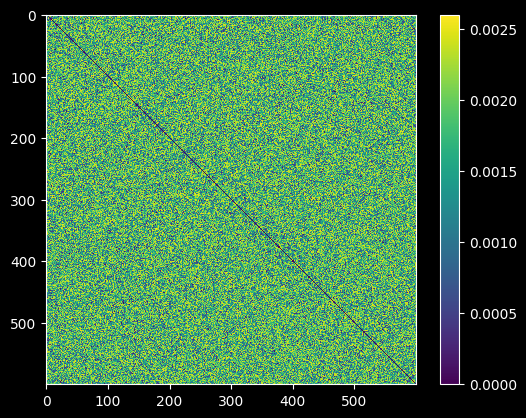

In [155]:
visualize_matrix(og_population[0])

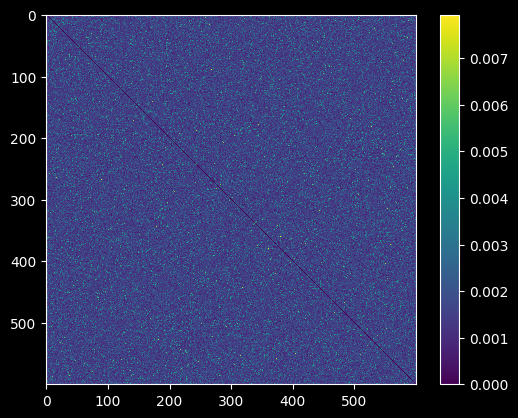

In [156]:
visualize_matrix(population[0])

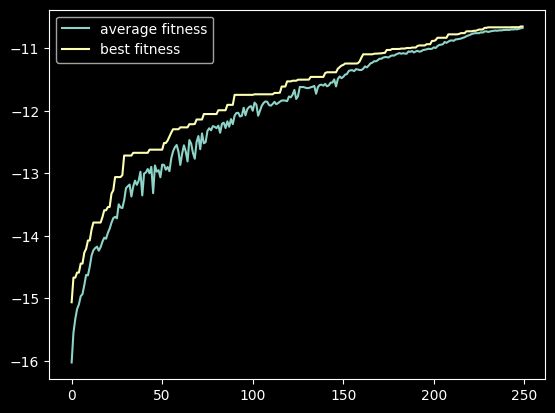

In [159]:
plt.plot(range(epochs), hist[:epochs, :epochs])
plt.legend(['average fitness', 'best fitness'])
plt.savefig('gen_algo_results_2')
plt.show()